# Simulate PD Response

This code models a photodetector response as a low pass filter. It applies that filter to the time domain signal of a laser sweeping through a resonance.

After playing around some, it seems like

$$f_{3dB} \gt 3 \frac{ \text{laser speed} }{ \Delta \lambda_{FWHM} }$$

Is usually okay

## Helper functions

In [1]:
from scipy.optimize import curve_fit
import numpy as np

c = 299792458
conversion = lambda pos, band: abs( c * band / ( pos ** 2 - ( band / 2 ) ** 2 ) )

def lorentzian(freq, freq_0, gamma, m):
    '''
    T = 1 - m G^2 / ( G^2 + (freq - freq_0) ^2 )
    |alpha| = |G|
    theta = G +- G sqrt( 1 - m )
    '''
    return 1 - m * gamma ** 2 / ( gamma ** 2 + (freq - freq_0) ** 2 )

def find_Q(frequency, transmission, fwhm_guess):
    f0_guess = frequency[np.argmin(transmission)]
    
    fit, pcov = curve_fit(lorentzian, frequency, transmission, [f0_guess, fwhm_guess / 2, 1])
    
    f0, gamma, m = fit
    alpha = gamma
    if m > 1 and ( m - 1 ) < 0.01:
        theta = gamma
        alpha_i = gamma
    else:
        theta = gamma + gamma * np.sqrt( 1 - m )
        alpha_i = gamma - gamma * np.sqrt( 1 - m )

    results = {
        'Q_int': f0 / alpha_i,
        'Q_ext': f0 / theta,
        'Q': f0 / ( alpha_i + theta ),
        'fit': fit
    }
    
    return results

## Interactive

interactive(children=(FloatSlider(value=15.0, description='Q_mil', min=0.1), IntSlider(value=1550, description…

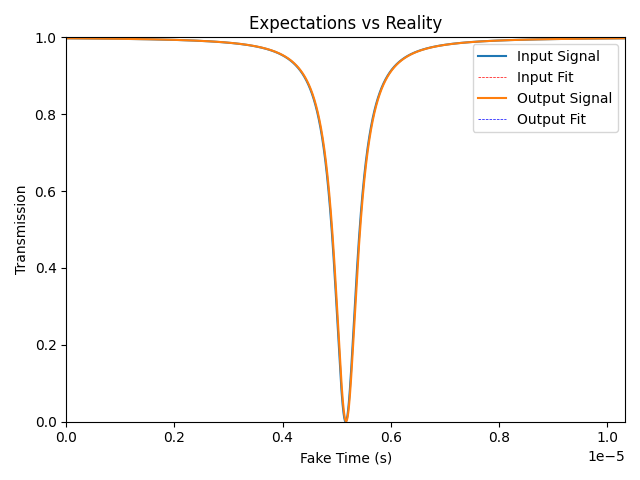

In [7]:
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider, FloatSlider
%matplotlib widget

fig, ax = plt.subplots()
line, = ax.plot([],[], 'C0', label='Input Signal')
line_fit, = ax.plot([],[], 'r--', linewidth=0.5, label='Input Fit')

line2, = ax.plot([],[], 'C1', label='Output Signal')
line2_fit, = ax.plot([],[], 'b--', linewidth=0.5, label='Output Fit')
plt.legend()
plt.xlabel('Fake Time (s)')
plt.ylabel('Transmission')
plt.title('Expectations vs Reality')

def simulate(Q_mil, wl0_nm, laser_speed_nm, f_3dB, plot_fits=False):
    Q = Q_mil * 1e6
    wl0 = wl0_nm / 1e9
    laser_speed = laser_speed_nm / 1e9
    f0 = c / wl0
    fwhm = f0 / Q
    gamma = fwhm / 2
    
    wl = np.linspace(wl0 - 10 * conversion(f0, fwhm), wl0 + 10 * conversion(f0, fwhm), 10000)
    f_optical = c / wl
    input_signal = np.abs( 1 - ( gamma ) / ( gamma + 1j * (f_optical - f0)) ) ** 2
    
    t = ( wl - wl[0] ) / laser_speed
    t_step = abs(np.mean(np.diff(t)))
    input_signal_f = np.fft.fft(input_signal)
    freq = np.fft.fftfreq(len(input_signal), t_step)
    
    RC = 1 / (2 * np.pi * f_3dB)
    
    lowpass_transfer = 1 / ( 2j * np.pi * freq * RC + 1 )
    
    output_signal_f = lowpass_transfer * input_signal_f
    output_signal = np.abs( np.fft.ifft(output_signal_f) )
    
    line.set_xdata(t)
    line.set_ydata(input_signal)
    line2.set_data(t, output_signal)
    # line2.set_ydata(output_signal)
    
    ax.set_xlim(min(t), max(t))
    ax.set_ylim(0, 1)

    in_res = find_Q(f_optical, input_signal, fwhm)
    out_res = find_Q(f_optical, output_signal, fwhm)
    if plot_fits:
        line_fit.set_data(t, lorentzian(f_optical, *in_res['fit']))
        line2_fit.set_data(t, lorentzian(f_optical, *out_res['fit']))
    print(f'''Detector 3dB bandwidth = {f_3dB/1e6:.3f}MHz | Laser Sweeping at {laser_speed*1e9:.0f}nm/s
    
Q Fits (theoretically: Q={Q/1e6:.0f} Mil)
Input:  Q={in_res['Q']/1e6:.2f} Mil, Qint={in_res['Q_int']/1e6:.2f} Mil, Qext={in_res['Q_ext']/1e6:.2f} Mil
Output: Q={out_res['Q']/1e6:.2f} Mil, Qint={out_res['Q_int']/1e6:.2f} Mil, Qext={out_res['Q_ext']/1e6:.2f} Mil''')
    plt.tight_layout()
    fig.canvas.draw()

interactive_plot = interactive(simulate, 
         Q_mil=FloatSlider(min=0.1, max=100, value=15), 
         wl0_nm=IntSlider(min=1000, max=2000, step=50, value=1550), 
         laser_speed_nm=IntSlider(min=1, max=200, step=1, value=200), 
         # f_3dB=IntSlider(min=1000, max=50e6, step=1, value=1.9e6)
         f_3dB=[('0dB', 17e6), ('10dB', 8.5e6), ('20dB', 1.9e6), ('30dB', 775e3), ('40dB', 320e3), ('50dB', 90e3), ('60dB', 33e3), ('70dB', 12e3)]
)
interactive_plot.children[-1].layout.width = '700px'
interactive_plot